In [1]:
import sys
sys.path.append("/home/hugo/projetos-doutorado/mimo_emb_fts/src/")
#sys.path.insert(0, '/home/hugo/projetos-doutorado/imp_doutorado/src/evolving_soda') 
import pandas as pd
import matplotlib.pyplot as plt
from embfts.models.NonStationaryFtsPca import NonStationaryFtsPca
from pyFTS.benchmarks import Measures
from pyFTS.models.nonstationary import nsfts
import math
import datetime
import statistics
import numpy as np
from pyFTS.common import Util
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statistics 

from embfts.util.DataSetUtil import DataSetUtil
from embfts.util.StatisticsUtil import StatisticsUtil


np.seterr(divide='ignore', invalid='ignore')

from pyFTS.models.nonstationary import partitioners as nspart
from pyFTS.models.nonstationary import nsfts

In [2]:
data_set_util = DataSetUtil()
statistics = StatisticsUtil()

In [74]:
df = pd.read_csv('/home/hugo/projetos-doutorado/mimo_emb_fts/data/energydata_complete.csv', sep=',')
data = df.drop(labels=['date','rv1','rv2'], axis=1)
data = data_set_util.clean_dataset(data)
data = data_set_util.series_to_supervised_miso(data, 1, 1, 'Appliances')
data.head()

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,RH_8(t-1),T9(t-1),RH_9(t-1),T_out(t-1),Press_mm_hg(t-1),RH_out(t-1),Windspeed(t-1),Visibility(t-1),Tdewpoint(t-1),Appliances(t)
1,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60.0
2,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,50.0
3,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50.0
4,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,60.0
5,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,50.0


In [75]:
data_train = data.loc[:,'Appliances(t-1)']
data_test = data.loc[:,'Appliances(t)']

Xtrain = data_set_util.sample_first_prows(data_train,0.75)
ytrain = data_set_util.sample_first_prows(data_test,0.75)

Xtest = data_train.iloc[max(Xtrain.index):]
ytest = data_test.iloc[max(ytrain.index):]

In [76]:
partitions = {'BTC-USD': {'BoxCox(0)': 34, 'Differential(1)': 6, 'None': 10},
 'CMIV': {'BoxCox(0)': 37, 'Differential(1)': 12, 'None': 17},
 'DowJones': {'BoxCox(0)': 38, 'Differential(1)': 15, 'None': 36},
 'ETH-USD': {'BoxCox(0)': 13, 'Differential(1)': 39, 'None': 12},
 'EUR-GBP': {'BoxCox(0)': 29, 'Differential(1)': 11, 'None': 35},
 'EUR-USD': {'BoxCox(0)': 29, 'Differential(1)': 11, 'None': 35},
 'GBP-USD': {'BoxCox(0)': 33, 'Differential(1)': 3, 'None': 37},
 'IMCV': {'BoxCox(0)': 36, 'Differential(1)': 32, 'None': 36},
 'IMIV': {'BoxCox(0)': 39, 'Differential(1)': 14, 'None': 6},
 'IMIV0': {'BoxCox(0)': 39, 'Differential(1)': 16, 'None': 3},
 'NASDAQ': {'BoxCox(0)': 39, 'Differential(1)': 15, 'None': 36},
 'SP500': {'BoxCox(0)': 33, 'Differential(1)': 7, 'None': 33},
 'TAIEX': {'BoxCox(0)': 39, 'Differential(1)': 31, 'None': 33}}

In [77]:
partitions['BTC-USD']['Differential(1)']

6

In [78]:
from pyFTS.common import Transformations
tdiff = Transformations.Differential(2)
boxcox = Transformations.BoxCox(0)

In [80]:
npart=50

nsfs = nspart.simplenonstationary_gridpartitioner_builder(data=Xtrain, npart=npart, transformation=boxcox)

In [81]:
model = nsfts.NonStationaryFTS(partitioner=nsfs, order=1, memory_window = 3)

In [82]:
model.fit(Xtrain.values)

In [83]:
forecast = model.forecast(Xtest.values,steps_ahead=1)

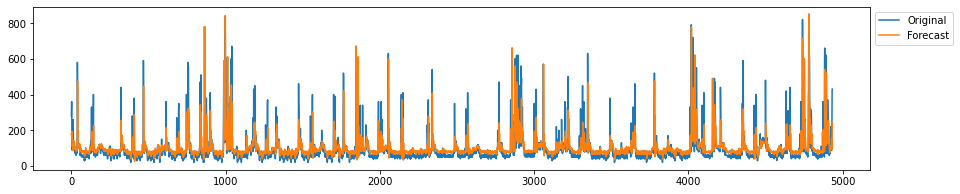

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
ax.plot(ytest.values, label='Original')
ax.plot(forecast, label='Forecast')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

In [85]:
mae = mean_absolute_error(ytest.values,forecast)
r2 = r2_score(ytest.values,forecast)
rmse = Measures.rmse(ytest.values,forecast)
mape = Measures.mape(ytest.values,forecast)

print(rmse)
print(mae)
print(r2)
print(mape)

69.04374281315724
36.90454795262865
0.3883589141861663
40.43711020134479


In [43]:
result = {
     "window": [],
     "rmse": [],
     "mape": [],
     "smape": [],
     "mae": [],
     "r2": []
}

steps_ahead = 1
tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        
        print('-' * 20)
        print(f'training window {(ct)}')
        
        Xtrain = ttrain.loc[:,'Appliances(t-1)']
        ytrain = ttrain.loc[:,'Appliances(t)']
        Xtest = ttest.loc[:,'Appliances(t-1)']
        ytest = ttest.loc[:,'Appliances(t)']
        
        npart=50
        nsfs = nspart.simplenonstationary_gridpartitioner_builder(data=Xtrain, npart=npart, transformation=boxcox)
        model = nsfts.NonStationaryFTS(partitioner=nsfs, order=1, memory_window = 3)
        model.fit(Xtrain.values)
        forecast = model.forecast(Xtest.values,steps_ahead=1)
        
        #print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        rmse = Measures.rmse(ytest.values,forecast)
        mape = Measures.mape(ytest.values,forecast)
        smape = Measures.smape(ytest.values,forecast)
        mae = mean_absolute_error(ytest.values, forecast)
        r2 = r2_score(ytest, forecast)
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(ytest.values, label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()
        
        result["rmse"].append(rmse)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["mae"].append(mae)
        result["r2"].append(r2)
        result["window"].append(ct)
        
        
measures = pd.DataFrame(result)

--------------------
training window 0


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [35]:
import statistics 

final_result = {
     "rmse": [],
     "mape": [],
     "smape": [],
     "mae": [],
     "r2": []
}

final_result["rmse"].append(statistics.mean(measures['rmse']))
final_result["mape"].append(statistics.mean(measures['mape']))
final_result["smape"].append(statistics.mean(measures['smape']))
final_result["mae"].append(statistics.mean(measures['mae']))
final_result["r2"].append(statistics.mean(measures['r2']))
        
final_measures = pd.DataFrame(final_result)

print("Mean Statistics NSFTS (test): ")
final_measures

Mean Statistics NSFTS (test): 


,rmse,mape,smape,mae,r2
0,69.892869,41.727837,17.228919,39.600459,0.1897
